# Jonathan Halverson
# Friday, October 27, 2017
# Logistic regression from scratch in TF

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('halverson')
%matplotlib inline

In [2]:
from sklearn.datasets import make_moons

In [3]:
X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)

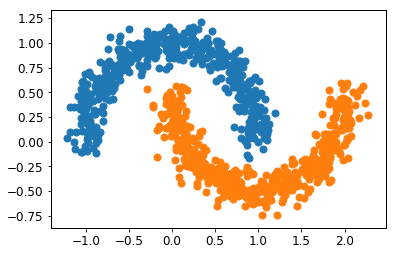

In [4]:
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

#### With regularization

In [6]:
pline = Pipeline([('std_sc', StandardScaler()), ('lr', LogisticRegression())])
param_grid = {'lr__C':np.logspace(-2, 2, num=10), 'lr__penalty':['l1', 'l2']}
grid_search = GridSearchCV(pline, param_grid, cv=10, scoring='accuracy', refit=True)
grid_search.fit(X, y).score(X, y)

0.879

In [7]:
grid_search.best_params_

{'lr__C': 0.027825594022071243, 'lr__penalty': 'l1'}

In [8]:
grid_search.best_estimator_.named_steps['lr'].intercept_, grid_search.best_estimator_.named_steps['lr'].coef_

(array([ 0.]), array([[ 0.69840189, -1.97208501]]))

#### Without regularization and standardization

In [9]:
lr = LogisticRegression(C=1e6).fit(X, y)
lr.score(X, y)

0.878

In [10]:
lr.intercept_, lr.coef_

(array([ 0.81672926]), array([[ 1.21835192, -5.87249285]]))

#### With standardization

In [11]:
X_std = StandardScaler().fit_transform(X)
lr = LogisticRegression().fit(X_std, y)
lr.score(X_std, y)

0.878

In [12]:
lr.intercept_, lr.coef_

(array([-0.02574942]), array([[ 1.04076416, -2.82987367]]))

### Brute force optimization

In [13]:
from scipy.special import expit

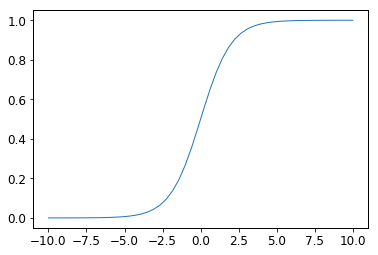

In [14]:
plt.plot(np.linspace(-10, 10), expit(np.linspace(-10, 10)))

In [15]:
expit(2.0), np.exp(2.0) / (1 + np.exp(2.0))

(0.88079707797788231, 0.88079707797788243)

In [16]:
np.log(2.7182)

0.99996989653910984

The cost function is

$ J(w_i) = \frac{1}{m}\sum_{i=1}^m [y_i \ln p_i + (1-y_i)\ln (1-p_i)] $

In [17]:
J_min = -1e6
best_values = None
for i in xrange(10000):
     intercept = 2 * (np.random.random() - 0.5)
     w1 = 4 * (np.random.random() - 0.5)
     w2 = 15 * (np.random.random() - 0.5)
     omega = np.dot(X, np.array([w1, w2])) + intercept
     p = expit(omega)
     J = y * np.log(p) + (1 - y) * np.log(1 - p)
     if J.sum() > J_min:
          J_min = J.sum()
          best_values = intercept, w1, w2

In [18]:
best_values

(0.8897782482447054, 1.208955317886394, -6.092418127742222)

### Logistic regression using gradient descent 

In [19]:
learning_rate = 0.01
epochs = 100000

In [20]:
theta = np.array([0.5, -0.5, 0.25])
X_bias = np.c_[np.ones((X.shape[0], 1)), X]

In [21]:
for epoch in xrange(epochs):
     errors = expit(np.dot(X_bias, theta)) - y
     gradients = (1.0 / X_bias.shape[0]) * np.dot(X_bias.T, errors)
     theta = theta - learning_rate * gradients
print(theta)

[ 0.81458852  1.21815169 -5.86380674]


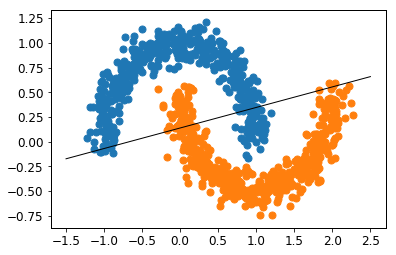

In [22]:
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
x = np.linspace(-1.5, 2.5)
plt.plot(x, -(theta[0] + theta[1] * x) / theta[2], 'k-')

#### From scratch implementation

In [23]:
import tensorflow as tf

In [24]:
tf.reset_default_graph()

In [25]:
features = X.copy()
labels = y.copy()

In [26]:
#features = np.c_[np.ones((features.shape[0], 1)), StandardScaler().fit_transform(features)]
#features[0:5]

In [27]:
epochs = 50000
learning_rate = 0.01

In [28]:
m = X_bias.shape[0]
Xr = tf.constant(X_bias, name="X", dtype=tf.float32)
yr = tf.constant(labels.reshape(-1, 1), name="y", dtype=tf.float32)
theta = tf.Variable(tf.random_uniform([3, 1], -1.0, 1.0), name='theta')

p = tf.exp(tf.matmul(Xr, theta)) / (1.0 + tf.exp(tf.matmul(Xr, theta)))
errors = p - yr
gradients = (1.0 / m) * tf.matmul(tf.transpose(Xr), errors)
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

In [29]:
with tf.Session() as sess:
     sess.run(init)
     for epoch in range(epochs):
          sess.run(training_op)
     best_theta = theta.eval()

In [30]:
best_theta

array([[ 0.78126478],
       [ 1.21308196],
       [-5.72328234]], dtype=float32)

In [31]:
# pg. 245 of Geron
#show_graph()

#### Compute the gradient using TF

In [32]:
tf.reset_default_graph()

In [33]:
m = X_bias.shape[0]
Xr = tf.constant(X_bias, name="X", dtype=tf.float32)
yr = tf.constant(labels.reshape(-1, 1), name="y", dtype=tf.float32)
theta = tf.Variable(tf.random_uniform([3, 1], -1.0, 1.0), name='theta')

# https://github.com/jhalverson/handson-ml/blob/master/09_up_and_running_with_tensorflow.ipynb
# logits = tf.matmul(Xr, theta)
# p = tf.sigmoid(logits) or
p = tf.exp(tf.matmul(Xr, theta)) / (1.0 + tf.exp(tf.matmul(Xr, theta)))
J = -tf.reduce_mean(yr * tf.log(p) + (1.0 - yr) * tf.log(1.0 - p), name="J")
# don't need (1/m) prefactor since reduce mean accounts for this
# J = tf.losses.log_loss(y, y_proba) or
# epsilon = 1e-7  # to avoid an overflow when computing the log
# J = -tf.reduce_mean(y * tf.log(y_proba + epsilon) + (1 - y) * tf.log(1 - y_proba + epsilon))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(J)
init = tf.global_variables_initializer()

In [34]:
with tf.Session() as sess:
     sess.run(init)
     for epoch in range(epochs):
          sess.run(training_op)
     best_theta = theta.eval()
best_theta

array([[ 0.77937144],
       [ 1.21283352],
       [-5.71536636]], dtype=float32)